In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

In [3]:
# 파일 불러오기
train = pd.read_csv('./data/train_std.csv')
test = pd.read_csv('./data/test_std.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
#train set x와 y

Y = train["target"].to_numpy()
X =train.drop(["target","id"],axis=1).to_numpy()

test = test.drop("id",axis=1)



In [5]:
test = test.to_numpy()

# stratified k-fold

In [6]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {0: 455, 1: 459, 2: 474, 3: 480}
검증 레이블 데이터 분포 : 
 {0: 114, 1: 115, 2: 119, 3: 119} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {0: 455, 1: 459, 2: 475, 3: 479}
검증 레이블 데이터 분포 : 
 {0: 114, 1: 115, 2: 118, 3: 120} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {0: 455, 1: 459, 2: 475, 3: 479}
검증 레이블 데이터 분포 : 
 {0: 114, 1: 115, 2: 118, 3: 120} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {0: 456, 1: 459, 2: 474, 3: 479}
검증 레이블 데이터 분포 : 
 {0: 113, 1: 115, 2: 119, 3: 120} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {0: 455, 1: 460, 2: 474, 3: 479}
검증 레이블 데이터 분포 : 
 {0: 114, 1: 114, 2: 119, 3: 120} 



# 데이터 정의

In [7]:
#train,valid set

from torch.utils.data import Dataset, DataLoader

classes = [0,1,2,3]
class hand_dataset(Dataset):
    def __init__(self,data_list,classes,data_num,training):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #training: train인지 valid 인지.
        
        self.data_list = data_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = hand_dataset.get_label(self.data_list,training,data_num)
        self.classes=classes

    
    @classmethod
    def get_label(cls,data_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.data_list)
        #데이터 셋의 길이를 정수로 반환한다.     
        
    def __getitem__(self, idx):

        data = self.data_list[idx]
        data = torch.from_numpy(data).unsqueeze(0).float()
        
        return data, self.classes.index(self.label[idx])

In [8]:
#train,valid set

from torch.utils.data import Dataset, DataLoader

classes = [0,1,2,3]
class hand_testset(Dataset):
    def __init__(self,data_list,classes):
        
        self.data_list = data_list
        self.classes = classes
    
    def __len__(self):
        return len(self.data_list)
        #데이터 셋의 길이를 정수로 반환한다.     
        
    def __getitem__(self, idx):

        data = self.data_list[idx]
        data = torch.from_numpy(data).unsqueeze(0).float()
        
        
        return data

# 데이터 로더

In [9]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 30 # 전체 데이터 셋을 50번 반복

In [10]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인



train_loader = torch.utils.data.DataLoader(dataset = 
                                           hand_dataset(
                                               X_train_list,
                                               classes,
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           hand_dataset(
                                               X_valid_list,
                                               classes,
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [11]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               hand_testset(
                                                   test,
                                                   classes,
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

X_train :  torch.Size([32, 1, 32]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(3)
tensor([[ 2.4487e-02, -5.1627e+00, -1.2144e+01, -7.9403e+00, -8.0559e+00,
          3.9699e+00,  5.8913e+01, -4.9723e+00,  1.1983e+01,  3.8207e+00,
          6.8024e+00, -3.9013e+01, -6.0320e+00, -4.9920e+00, -6.2949e+01,
          9.1685e-01,  4.9545e+00,  2.1066e+01,  7.5772e+01,  8.3343e-01,
         -3.0646e+00, -2.0043e+01, -6.1082e+00,  2.1124e+01, -8.0918e+00,
          1.0036e+01, -3.5989e+01,  7.8271e+00, -2.9084e+00, -3.9958e+01,
          3.4107e+01, -1.6886e+01]])


Text(0.5, 1.0, 'sensor of hand')

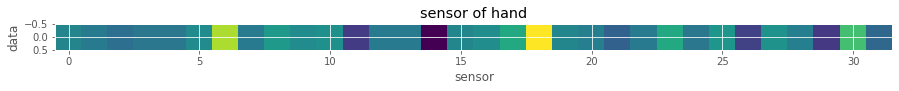

In [12]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
print(X_train[0])
plt.figure(figsize=(15,5))
plt.imshow(X_train[0].view(1,32).numpy())
plt.xlabel("sensor")
plt.ylabel("data")
#plt.colorbar(format='%+2.0f dB')
plt.title("sensor of hand")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 1, 32]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(3)
tensor([[  1.8885,  -3.0437, -41.0901, -43.0242, -16.0552,  21.9343,  44.0315,
           4.1619,  -6.9821,   6.0110,  21.0982,  14.0732,   6.0855,  -4.8612,
          13.1667,   2.1077,  13.0893,  -9.8947, -12.8663,  23.8617, -22.0310,
          10.8511,  10.0884,  -5.1244,   4.0095,   8.0616, -15.1404,  -1.0966,
         -10.0917,  -5.0388, -23.9928,   3.1290]])


Text(0.5, 1.0, 'sensor of hand')

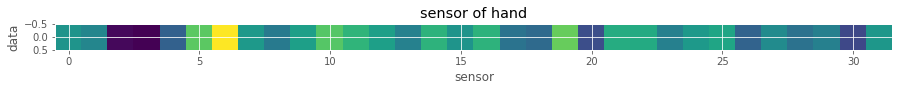

In [13]:
# 4. 데이터 확인하기
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break
    
print(Y_valid[0])
print(X_valid[0])
plt.figure(figsize=(15,5))
plt.imshow(X_valid[0].view(1,32).numpy())
plt.xlabel("sensor")
plt.ylabel("data")
#plt.colorbar(format='%+2.0f dB')
plt.title("sensor of hand")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_test :  torch.Size([32, 1, 32]) type: torch.FloatTensor
tensor([[-28.9515,   3.0138,  -7.9581, -10.0844,  -3.1058,  -1.0383, -21.0362,
          14.0296,  -4.8264,  -0.9968,  15.0197, -24.0876,  -0.9339,  -6.0702,
          43.9328,   1.0860,   5.0313,  -1.1749,  -0.7839,  -0.1070,   8.8221,
           5.0790, -14.9282, -22.9981,  11.1138,  -5.9961,  -7.9996,  10.0672,
          12.9769,   5.9578, -19.0247,  10.9627]])


Text(0.5, 1.0, 'sensor of hand')

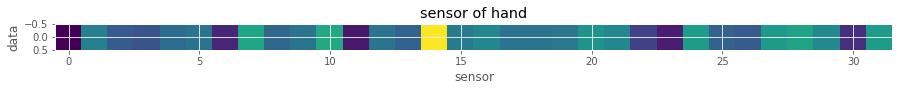

In [14]:
# 4. 데이터 확인하기
for (X_test) in test_loader:
    print("X_test : ",X_test.size(),'type:',X_test.type())
    break
    

print(X_test[0])
plt.figure(figsize=(15,5))
plt.imshow(X_test[0].view(1,32).numpy())
plt.xlabel("sensor")
plt.ylabel("data")
#plt.colorbar(format='%+2.0f dB')
plt.title("sensor of hand")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# 1d CNN


In [44]:
#모델  실험

torch.randn((1,32))

testmodel=nn.Conv1d(
                in_channels = 1,
                out_channels = 8,
                kernel_size = (16)
            )
# torch.Size([32, 4, 29])
testmodel2=nn.Conv1d(
                in_channels = 8,
                out_channels = 16,
                kernel_size = (8)
            )
# torch.Size([32, 8, 22])
testmodel3=nn.Conv1d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = (4)
            )         
# torch.Size([32, 16, 7])
dat1=testmodel(X_train)
print(dat1.size())
dat2=testmodel2(dat1)
print(dat2.size())
dat3=testmodel3(dat2)
print(dat3.size())
?F.adaptive_avg_pool1d
F.adaptive_avg_pool1d(dat3,1).size()


torch.Size([32, 8, 17])
torch.Size([32, 16, 10])
torch.Size([32, 32, 7])


torch.Size([32, 32, 1])

In [62]:
class Net(nn.Module):
    def __init__(self,n_class=4):
        super(Net,self).__init__() # 상속받기
        self.cnn1 = nn.Conv1d(
                in_channels = 1,
                out_channels = 8,
                kernel_size = (16)
            )
        self.norm1= nn.BatchNorm1d(8)
        self.cnn2 = nn.Conv1d(
                in_channels = 8,
                out_channels = 16,
                kernel_size = (8)
            )
        self.norm2= nn.BatchNorm1d(16)
        
        self.cnn3 = nn.Conv1d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = (4)
            )
        self.norm3= nn.BatchNorm1d(32)
        
        self.fc = nn.Sequential(
            nn.Linear(32*7,100),
            nn.Linear(100,n_class)
        )
        
        
    
    def forward(self,x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = x.view(-1,32*7)
        x = self.fc(x)
        
        return x

In [63]:
#7. Optimizer, Objective Function
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
#원핫 인코딩값의 loss는 crossEntropyLoss로 비교
print(model)

Net(
  (cnn1): Conv1d(1, 8, kernel_size=(16,), stride=(1,))
  (norm1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn2): Conv1d(8, 16, kernel_size=(8,), stride=(1,))
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn3): Conv1d(16, 32, kernel_size=(4,), stride=(1,))
  (norm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=224, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=4, bias=True)
  )
)


In [64]:
#7. Optimizer, Objective Function
def model_initialize():
    model = Net().to(DEVICE)
    #원핫 인코딩값의 loss는 crossEntropyLoss로 비교
    #print(model)
    return model

In [65]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [66]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [67]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               hand_dataset(
                                                   X_train_list,
                                                   classes,
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               hand_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [68]:
#10. 학습 및 평가.
# 1d cnn
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_1dcnn_'+str(data_ind)+'.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

./checkpoint/checkpoint_1dcnn_1.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0459	 Train Acc:26.87 %  | 	Valid Loss:0.0449 	Valid Acc: 30.84 %

Validation loss decreased (inf --> 0.044853).  Saving model ...

[EPOCH:2]	 Train Loss:0.0443	 Train Acc:28.43 %  | 	Valid Loss:0.0445 	Valid Acc: 30.19 %

Validation loss decreased (0.044853 --> 0.044534).  Saving model ...

[EPOCH:3]	 Train Loss:0.0442	 Train Acc:28.32 %  | 	Valid Loss:0.0445 	Valid Acc: 32.33 %

EarlyStopping counter: 1 out of 10

[EPOCH:4]	 Train Loss:0.0442	 Train Acc:29.39 %  | 	Valid Loss:0.0450 	Valid Acc: 29.98 %

EarlyStopping counter: 2 out of 10

[EPOCH:5]	 Train Loss:0.0441	 Train Acc:28.21 %  | 	Valid Loss:0.0447 	Valid Acc: 32.33 %

EarlyStopping counter: 3 out of 10

[EPOCH:6]	 Train Loss:0.0440	 Train Acc:31.80 %  | 	Valid Loss:0.0447 	Valid Acc: 32.12 %

EarlyStopping counter: 4 out of 10

[EPOCH:7]	 Train Loss:0.0440	 Train Acc:30.51 %  | 	Valid Loss:0.0449 	Valid Acc: 31.26 %

EarlyStopping counter: 5 


[EPOCH:5]	 Train Loss:0.0438	 Train Acc:29.01 %  | 	Valid Loss:0.0455 	Valid Acc: 27.84 %

EarlyStopping counter: 2 out of 10

[EPOCH:6]	 Train Loss:0.0439	 Train Acc:29.93 %  | 	Valid Loss:0.0454 	Valid Acc: 29.12 %

EarlyStopping counter: 3 out of 10

[EPOCH:7]	 Train Loss:0.0438	 Train Acc:31.53 %  | 	Valid Loss:0.0459 	Valid Acc: 29.55 %

EarlyStopping counter: 4 out of 10

[EPOCH:8]	 Train Loss:0.0438	 Train Acc:30.14 %  | 	Valid Loss:0.0452 	Valid Acc: 29.55 %

EarlyStopping counter: 5 out of 10

[EPOCH:9]	 Train Loss:0.0438	 Train Acc:31.48 %  | 	Valid Loss:0.0452 	Valid Acc: 28.69 %

EarlyStopping counter: 6 out of 10

[EPOCH:10]	 Train Loss:0.0437	 Train Acc:31.42 %  | 	Valid Loss:0.0453 	Valid Acc: 29.12 %

EarlyStopping counter: 7 out of 10

[EPOCH:11]	 Train Loss:0.0437	 Train Acc:33.03 %  | 	Valid Loss:0.0458 	Valid Acc: 27.19 %

EarlyStopping counter: 8 out of 10

[EPOCH:12]	 Train Loss:0.0437	 Train Acc:30.73 %  | 	Valid Loss:0.0453 	Valid Acc: 32.98 %

EarlyStopping co